In [7]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install plotnine --quiet
!pip install torch_geometric  --quiet
!pip install torch_geometric  --quiet
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html --quiet
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html  --quiet
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git   --quiet

1.12.1+cu113


# Imports

In [20]:
import torch.nn.functional as F
from torch.nn import Parameter as Param
from torch.nn import Parameter, Module
from torch.nn import Sequential, Linear, ReLU
from torch.optim import Optimizer
from torch import Tensor
from torch import nn
from torch.optim.sgd import SGD
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv,ChebConv,GATConv
from torch_geometric.utils import get_laplacian
from torch_geometric.utils import to_scipy_sparse_matrix
from torch_geometric.nn import GatedGraphConv
from torch_geometric.nn import MessagePassing, SAGEConv, GINConv, global_add_pool
from torch_geometric.nn.inits import uniform
from torch.optim.adam import Adam

import os.path as osp

from typing import Callable, List, Optional, Tuple
from typing_extensions import Literal, TypedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from tqdm.notebook import trange, tqdm
import copy
import random
import time
import  math
import itertools
from functools import reduce
import operator
import torch.utils.data as data_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from torch.utils.data import Subset
from plotnine import ggplot, geom_line, aes, xlab, theme, element_blank, ggtitle
from collections import OrderedDict
from typing_extensions import Literal, TypedDict
from torch_sparse import SparseTensor
from torch_scatter import gather_csr, scatter, segment_csr

import inspect
from torch.utils.data import DataLoader
device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')

# Datasets initial exploration

In [9]:
dataset=list(range(3))
i=0
for dataset_name in ['Cora','CiteSeer','PubMed']:
    dataset[i] = Planetoid('/tmp/dataset_name', name=dataset_name)
    num_nodes = dataset[i].data.num_nodes
    num_edges = dataset[i].data.num_edges // 2
    train_len = dataset[i][0].train_mask.sum()
    val_len = dataset[i][0].val_mask.sum()
    test_len = dataset[i][0].test_mask.sum()
    other_len = num_nodes - train_len - val_len - test_len
    print(f"Dataset: {dataset[i].name}")
    print(f"Num. nodes: {num_nodes} (train={train_len}, val={val_len}, test={test_len}, other={other_len})")
    print(f"Num. edges: {num_edges}")
    print(f"Num. node features: {dataset[i].num_node_features}")
    print(f"Num. classes: {dataset[i].num_classes}")
    print(f"Dataset len.: {dataset[i].len()}")
    i=i+1
    print(" ")

Processing...
Done!


Dataset: Cora
Num. nodes: 2708 (train=140, val=500, test=1000, other=1068)
Num. edges: 5278
Num. node features: 1433
Num. classes: 7
Dataset len.: 1
 


Processing...
Done!


Dataset: CiteSeer
Num. nodes: 3327 (train=120, val=500, test=1000, other=1707)
Num. edges: 4552
Num. node features: 3703
Num. classes: 6
Dataset len.: 1
 


Dataset: PubMed
Num. nodes: 19717 (train=60, val=500, test=1000, other=18157)
Num. edges: 44324
Num. node features: 500
Num. classes: 3
Dataset len.: 1
 


Processing...
Done!


# Glorot Normalization

In [11]:
dataset[0] = Planetoid("/tmp/Cora", name="Cora")
print(f"Sum of row values without normalization: {dataset[0][0].x.sum(dim=-1)}")

dataset[0] = Planetoid("/tmp/Cora", name="Cora", transform=T.NormalizeFeatures())
print(f"Sum of row values with normalization: {dataset[0][0].x.sum(dim=-1)}")
print(" ")

dataset[1] = Planetoid("/tmp/CiteSeer", name="CiteSeer")
print(f"Sum of row values without normalization: {dataset[1][0].x.sum(dim=-1)}")

dataset[1] = Planetoid("/tmp/CiteSeer", name="CiteSeer", transform=T.NormalizeFeatures())
print(f"Sum of row values with normalization: {dataset[1][0].x.sum(dim=-1)}")
print(" ")

dataset[2] = Planetoid("/tmp/PubMed", name="PubMed")
print(f"Sum of row values without normalization: {dataset[2][0].x.sum(dim=-1)}")

dataset[2] = Planetoid("/tmp/PubMed", name="PubMed", transform=T.NormalizeFeatures())
print(f"Sum of row values with normalization: {dataset[2][0].x.sum(dim=-1)}")


Sum of row values without normalization: tensor([ 9., 23., 19.,  ..., 18., 14., 13.])
Sum of row values with normalization: tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])
 
Sum of row values without normalization: tensor([31., 33., 25.,  ..., 40., 36., 26.])
Sum of row values with normalization: tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])
 
Sum of row values without normalization: tensor([1.5913, 1.6492, 1.8888,  ..., 1.7013, 2.0314, 1.8369])
Sum of row values with normalization: tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])


# 2 layer GCN set-up as in the paper

In [13]:
class GCN(torch.nn.Module):
    
    def __init__(
        self,
        num_node_features:int,
        num_classes:int, 
        hidden_dim: int=16,
        dropout_rate: float=0.1,
        num_hidden_layers=0,
        residual=False
        ) -> None: 
        super().__init__()
        self.dropout1=torch.nn.Dropout(dropout_rate)
        self.conv1=GCNConv(num_node_features, hidden_dim)
        self.relu=torch.nn.ReLU(inplace=True)
        self.hidden_convs =  torch.nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)])
        self.dropout2=torch.nn.Dropout(dropout_rate)
        self.conv2=GCNConv(hidden_dim, num_classes)

    def forward(self, x:Tensor, edge_index: Tensor)-> torch.Tensor:
            x=self.dropout1(x)
            x=self.conv1(x, edge_index)
            x=self.relu(x)
            for conv in self.hidden_convs:
                if residual:
                    x = self.relu(conv(x, edge_index)) + x
                else:
                    x = self.relu(conv(x, edge_index))
            x=self.dropout2(x)
            x=self.conv2(x, edge_index)
            return x


In [21]:
print(GCN(dataset[0].num_node_features, dataset[0].num_classes,num_hidden_layers=3,residual=False))


GCN(
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv1): GCNConv(1433, 16)
  (relu): ReLU(inplace=True)
  (hidden_convs): ModuleList(
    (0): GCNConv(16, 16)
    (1): GCNConv(16, 16)
    (2): GCNConv(16, 16)
  )
  (dropout2): Dropout(p=0.1, inplace=False)
  (conv2): GCNConv(16, 7)
)


In [22]:
    
print("Graph Convolutional Network (GCN):")
print(GCN(dataset[0].num_node_features, dataset[0].num_classes))

    
print("Graph Convolutional Network (GCN):")
print(GCN(dataset[1].num_node_features, dataset[1].num_classes))

    
print("Graph Convolutional Network (GCN):")
print(GCN(dataset[2].num_node_features, dataset[2].num_classes))



Graph Convolutional Network (GCN):
GCN(
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv1): GCNConv(1433, 16)
  (relu): ReLU(inplace=True)
  (hidden_convs): ModuleList()
  (dropout2): Dropout(p=0.1, inplace=False)
  (conv2): GCNConv(16, 7)
)
Graph Convolutional Network (GCN):
GCN(
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv1): GCNConv(3703, 16)
  (relu): ReLU(inplace=True)
  (hidden_convs): ModuleList()
  (dropout2): Dropout(p=0.1, inplace=False)
  (conv2): GCNConv(16, 6)
)
Graph Convolutional Network (GCN):
GCN(
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv1): GCNConv(500, 16)
  (relu): ReLU(inplace=True)
  (hidden_convs): ModuleList()
  (dropout2): Dropout(p=0.1, inplace=False)
  (conv2): GCNConv(16, 3)
)


# Train and eval steps

In [29]:
# we reb not using the original implementation of he framework 
# in fact we re using the model provided by Pytorch
LossFn= Callable[[Tensor, Tensor], Tensor]
Stage= Literal["train", "val", "test"]

def train_step(
    model: torch.nn.Module, data:Data, optimizer: torch.optim.Optimizer, loss_fn:LossFn)-> Tuple[float, float]:
    model.train()
    optimizer.zero_grad()
    mask=data.train_mask
    logits=model(data.x, data.edge_index)[mask]
    preds=logits.argmax(dim=1)
    y=data.y[mask]
    loss= loss_fn(logits, y)
    acc=accuracy_score(preds, y)
    loss.backward()
    optimizer.step()
    return loss.item(), acc


@torch.no_grad()
def eval_step(model:torch.nn.Module, data:Data, loss_fn:LossFn, stage:Stage)-> Tuple[float, float]:
    model.eval()
    mask=getattr(data, f"{stage}_mask")
    logits=model(data.x, data.edge_index)[mask]
    preds=logits.argmax(dim=1)
    y=data.y[mask]
    loss=loss_fn(logits, y)
    acc=accuracy_score(preds, y)
    return loss.item(), acc 





In [30]:
class HistoryDict(TypedDict):
    loss: List[float]
    acc: List[float]
    val_loss: List[float]
    val_acc: List[float]

def train(
    model: torch.nn.Module,
    data: Data,
    optimizer: torch.optim.Optimizer,
    loss_fn: LossFn = torch.nn.CrossEntropyLoss(),
    max_epochs: int = 200,
    early_stopping: int = 10,
    print_interval: int = 20,
    verbose: bool = False,
) -> HistoryDict:
    history = {"loss": [], "val_loss": [], "acc": [], "val_acc": [],"test_acc":[],"test_loss":[]}
    for epoch in range(max_epochs):
        loss, acc = train_step(model, data, optimizer, loss_fn)
        val_loss, val_acc = eval_step(model, data, loss_fn, "val")
        history["loss"].append(loss)
        history["acc"].append(acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        # The official implementation in TensorFlow is a little different from what is described in the paper...
        if epoch > early_stopping and val_loss > np.mean(history["val_loss"][-(early_stopping + 1) : -1]):
            if verbose:
                print("\nEarly stopping...")

            break

        if verbose and epoch % print_interval == 0:
            print(f"\nEpoch: {epoch}\n----------")
            print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
            print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")

    test_loss, test_acc = eval_step(model, data, loss_fn, "test")
    if verbose:
        print(f"\nEpoch: {epoch}\n----------")
        print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
        print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
        print(f" Test loss: {test_loss:.4f} |  Test acc: {test_acc:.4f}")
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)
    return history
def plot_history(history: HistoryDict, title: str, font_size: Optional[int] = 14) -> None:
    plt.suptitle(title, fontsize=font_size)
    ax1 = plt.subplot(121)
    ax1.set_title("Loss")
    ax1.plot(history["loss"], label="train")
    ax1.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.set_title("Accuracy")
    ax2.plot(history["acc"], label="train")
    ax2.plot(history["val_acc"], label="val")
    plt.xlabel("Epoch")
    ax2.legend()

In [31]:
SEED = 42
MAX_EPOCHS = 200
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4
EARLY_STOPPING = 10

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GCN(dataset[0].num_node_features, dataset[0].num_classes).to(device)
data = dataset[0][0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

model2 = GCN(dataset[1].num_node_features, dataset[1].num_classes).to(device)
data2 = dataset[1][0].to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history2 = train(model2, data2, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

model3 = GCN(dataset[2].num_node_features, dataset[2].num_classes).to(device)
data3 = dataset[2][0].to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history3= train(model3, data3, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)


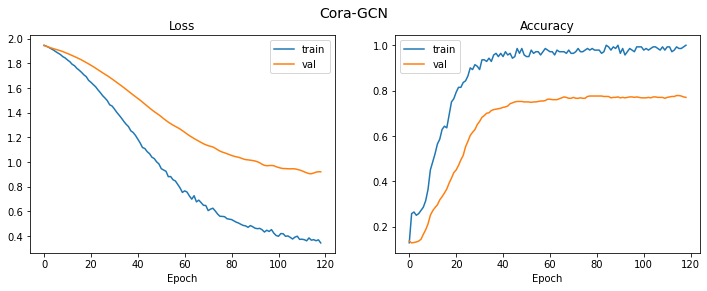

In [32]:
plt.figure(figsize=(12, 4))
plot_history(history, "Cora-GCN")



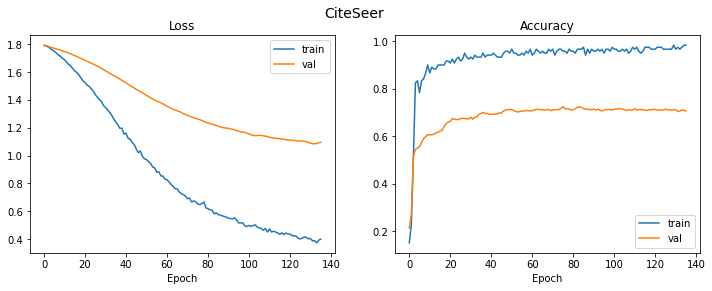

In [33]:
plt.figure(figsize=(12, 4))
plot_history(history2, "CiteSeer")

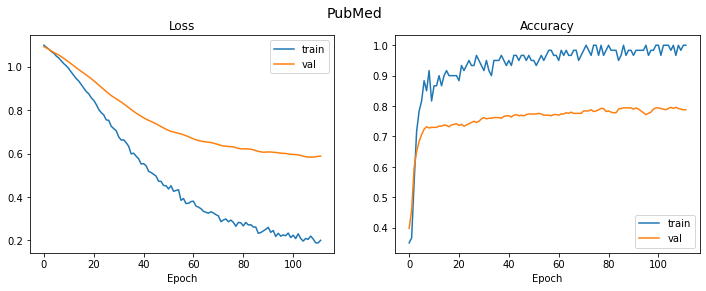

In [34]:
plt.figure(figsize=(12, 4))
plot_history(history3, "PubMed")

# ChebNet Convolution 

In [35]:
from torch 

SyntaxError: ignored

In [36]:
data = dataset[0][0].to(device)


In [37]:
class ChebNet(torch.nn.Module):
    def __init__(
        self,
        num_node_features:int,
        num_classes:int, 
        hidden_dim: int=16,
        dropout_rate: float=0.2,
        k=2,
        num_hidden_layers=0,
        residual=False
        ) -> None: 
        super().__init__()
        self.dropout1=torch.nn.Dropout(dropout_rate)
        self.conv1=ChebConv(num_node_features, hidden_dim,k)
        self.relu=torch.nn.ReLU(inplace=True)
        self.hidden_convs =  torch.nn.ModuleList([ChebConv(hidden_dim, hidden_dim, k) for _ in range(num_hidden_layers)])
        self.dropout2=torch.nn.Dropout(dropout_rate)
        self.conv2=ChebConv(hidden_dim, num_classes,k)

    def forward(self, x:Tensor, edge_index: Tensor)-> torch.Tensor:
            
            x=self.dropout1(x)
            x=self.conv1(x, edge_index)
            x=self.relu(x)
            for conv in self.hidden_convs:
                if residual:
                    x = self.relu(conv(x, edge_index)) + x
                else:
                    x = self.relu(conv(x, edge_index))
            x=self.dropout2(x)
            x=self.conv2(x, edge_index)
            return x

In [38]:
print(ChebNet(dataset[0].num_node_features, dataset[0].num_classes, num_hidden_layers=0))


ChebNet(
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv1): ChebConv(1433, 16, K=2, normalization=sym)
  (relu): ReLU(inplace=True)
  (hidden_convs): ModuleList()
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv2): ChebConv(16, 7, K=2, normalization=sym)
)


In [39]:
print("Graph Convolutional Network (GCN):")
print(ChebNet(dataset[0].num_node_features, dataset[0].num_classes))



Graph Convolutional Network (GCN):
ChebNet(
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv1): ChebConv(1433, 16, K=2, normalization=sym)
  (relu): ReLU(inplace=True)
  (hidden_convs): ModuleList()
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv2): ChebConv(16, 7, K=2, normalization=sym)
)


In [44]:
model4 = ChebNet(dataset[0].num_node_features, dataset[0].num_classes).to(device)
data = dataset[0][0].to(device)
optimizer = torch.optim.Adam(model4.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history4 = train(model4, data, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

model5 = ChebNet(dataset[1].num_node_features, dataset[1].num_classes).to(device)
data2 = dataset[1][0].to(device)
optimizer = torch.optim.Adam(model5.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history5 = train(model5, data2, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

model6 = ChebNet(dataset[2].num_node_features, dataset[2].num_classes).to(device)
data3 = dataset[2][0].to(device)
optimizer = torch.optim.Adam(model6.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history6= train(model6, data3, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)


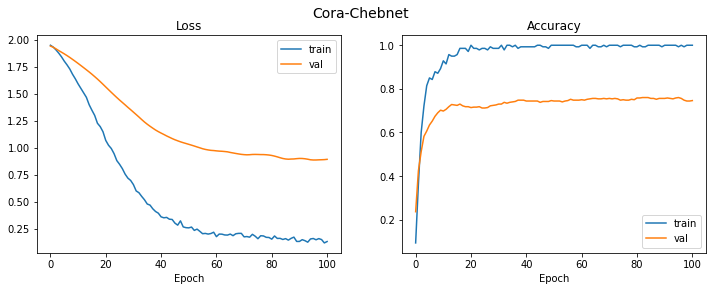

In [45]:
plt.figure(figsize=(12, 4))
plot_history(history4, "Cora-Chebnet")

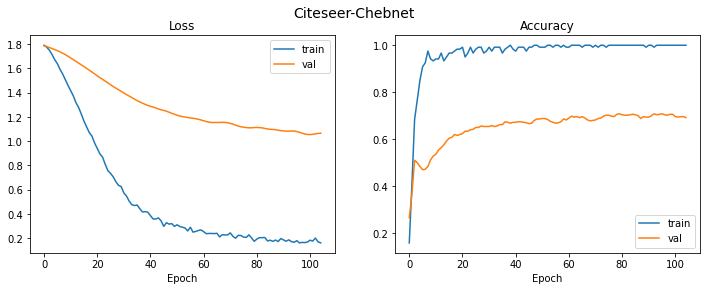

In [46]:
plt.figure(figsize=(12, 4))
plot_history(history5, "Citeseer-Chebnet")

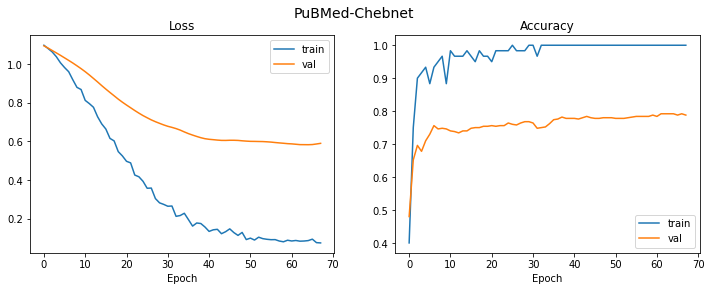

In [47]:
plt.figure(figsize=(12, 4))
plot_history(history6, "PuBMed-Chebnet")

# Model depth experiments and effect of residual connections 

In [ ]:
model = GCN(dataset[0].num_node_features, dataset[0].num_classes).to(device)
data = dataset[0][0].to(device)


In [ ]:
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [ ]:
hidden_layers= list(range(9))
#dataset[0]
def compute_accuracy_per_hidden_layer_num(data,residual,hidden_layers):
    overall_train_accs, overall_test_accs = [], []
    num_node_features=data.num_node_features
    num_classes=data.num_classes
    data = data[0].to(device)
    train_accs, test_accs = [], []
    for i in hidden_layers:
        
        model = GCN(num_node_features, num_classes,num_hidden_layers=i,residual=residual).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        history = train(model, data, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)
        train_accs.append(history['acc'][-1])
        test_loss, test_acc = eval_step(model, data, torch.nn.CrossEntropyLoss(), "test")
        test_accs.append(test_acc)

    return train_accs,test_accs

In [ ]:
def compute_residual_effect_df(data):
    SEED = 42
    MAX_EPOCHS = 200
    LEARNING_RATE = 0.01
    WEIGHT_DECAY = 5e-4
    EARLY_STOPPING = 10
    hidden_layers = list(range(9))
    train_accs, test_accs=compute_accuracy_per_hidden_layer_num(data,True,hidden_layers=hidden_layers)
    res_train_accs, res_test_accs=compute_accuracy_per_hidden_layer_num(data,False,hidden_layers=hidden_layers)
    h = len(hidden_layers)
    print(train_accs, test_accs)
    print(res_train_accs, res_test_accs)
    df = pd.DataFrame({
        "Layer": hidden_layers * 4,
        "Accuracy": train_accs + test_accs + res_train_accs + res_test_accs,
        "Type": ["Train"] * h + ["Test"] * h + ["Train"] * h + ["Test"] * h,
        "Residual": ["No residual"] * (2 * h) + ["Residual"] * (2 * h)
    })
    return df

In [ ]:
df=compute_residual_effect_df(dataset[0])

[0.9928571428571429, 1.0, 0.9714285714285714, 0.9571428571428572, 0.9785714285714285, 0.9571428571428572, 0.9142857142857143, 0.9571428571428572, 0.7142857142857143] [0.807, 0.805, 0.75, 0.676, 0.697, 0.728, 0.714, 0.674, 0.592]
[0.9785714285714285, 0.9928571428571429, 0.9857142857142858, 0.9714285714285714, 0.9571428571428572, 0.8071428571428572, 0.7428571428571429, 0.8857142857142857, 0.6357142857142857] [0.801, 0.784, 0.734, 0.741, 0.703, 0.584, 0.63, 0.612, 0.465]


In [ ]:
def plot_residual_effect(df, dataset):
    print(ggplot(df, aes(x="Layer", y="Accuracy", color="factor(Type)", linetype="factor(Residual)")) +
      geom_line() + 
      theme(legend_title=element_blank()) + 
      xlab("Number of hidden layers") +
      ggtitle(f"Accuracy vs number of hidden layers (residual/no residual) - {dataset.name}")
    )

In [ ]:
%%capture
df_cora = compute_residual_effect_df(dataset[0])
plot_residual_effect(df_cora, dataset[0])

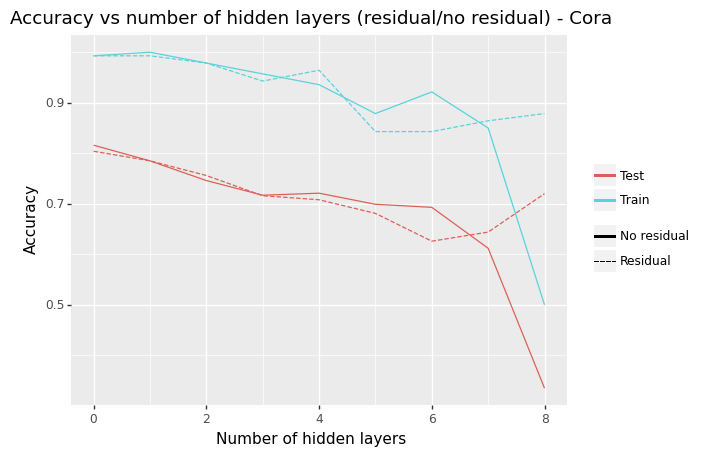

In [ ]:
plot_residual_effect(df_cora, dataset[0])

In [ ]:
%%capture
df_citeseer = compute_residual_effect_df(dataset[1])


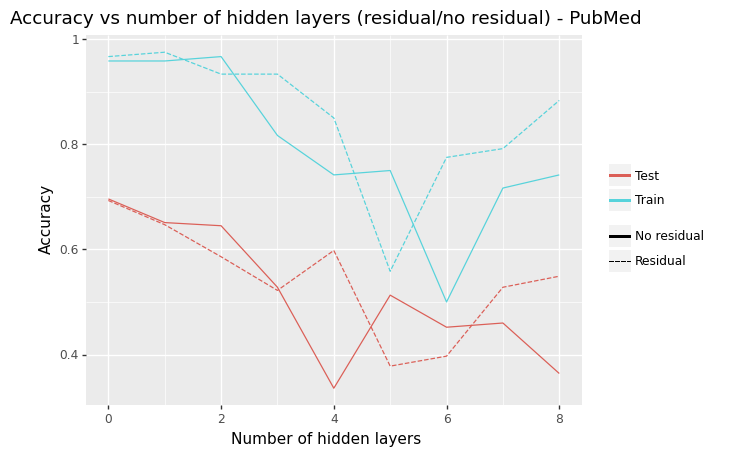

In [ ]:
plot_residual_effect(df_citeseer, dataset[2])

In [ ]:
%%capture
df_pubmed = compute_residual_effect_df(dataset[2])


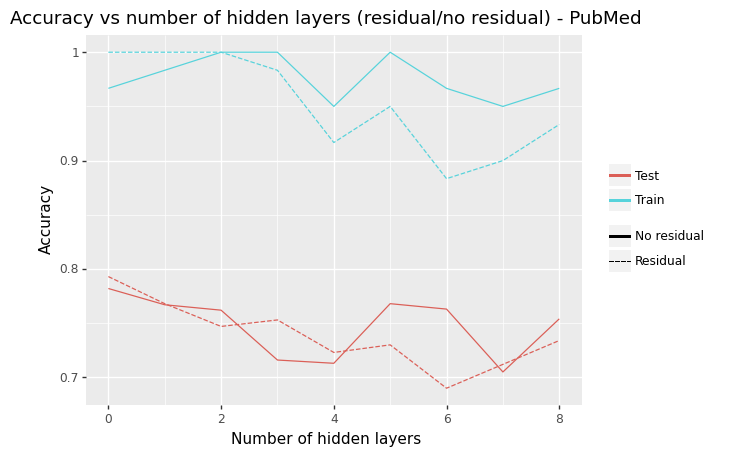

In [ ]:
plot_residual_effect(df_pubmed, dataset[2])